In [28]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#set random seed
tf.random.set_seed(42)

In [2]:
file_path = 'Yoga Dataset'

In [3]:
#set image size & batch size
image_size = (224, 224)
batch_size = 32

In [49]:
#image datagenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8,1.2],
    fill_mode='nearest'
    ,validation_split=0.2,
)

train_gen = train_datagen.flow_from_directory(
    file_path, target_size=image_size,
    batch_size=batch_size, class_mode='categorical',
    subset='training', shuffle=True)

val_gen = train_datagen.flow_from_directory(
    file_path, target_size=image_size,
    batch_size=batch_size, class_mode='categorical',
    subset='validation', shuffle=False)

Found 1045 images belonging to 5 classes.
Found 259 images belonging to 5 classes.


<Figure size 1200x500 with 0 Axes>

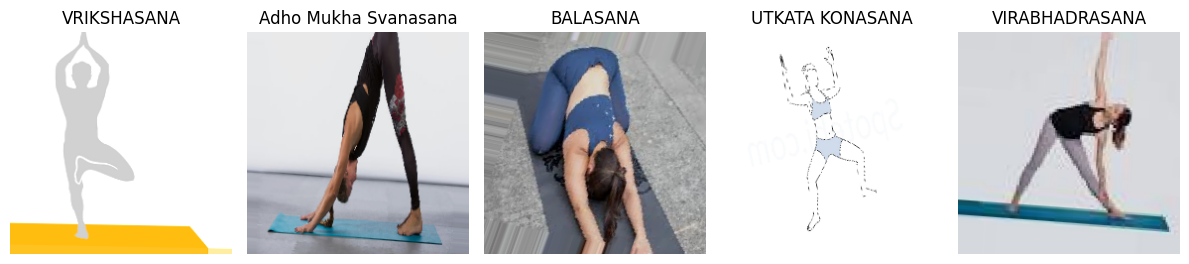

In [50]:
#show images of each class
images, labels = next(train_gen) #images and labels from the generator, images are 5D numpy arrays while labels are 2D numpy arrays. next comes with one hot encoded labels
class_names = list(train_gen.class_indices.keys()) #class names from the generator

images_per_class = {} #empty dict to store images per class
plt.figure(figsize = (12, 5))
for i in range (images.shape[0]):
    predicted_class_index = np.argmax(labels[i]) #get the index of the class with highest probability
    predicted_class = class_names[predicted_class_index] #get the class name from the index
    if predicted_class not in images_per_class:
        images_per_class[predicted_class] = images[i] #if class not in dict, add it

    if len(images_per_class) == len(class_names):
            break

plt.figure(figsize=(12, 5))
i = 1
for class_name, image in images_per_class.items():
    plt.subplot(2, len(images_per_class), i)
    if image.shape[-1] == 1:
        # Grayscale to RGB
        image = np.squeeze(image)
        plt.imshow(image, cmap='gray')
    else:
        # RGB: rescale if needed
        plt.imshow((image * 255).astype("uint8"))
    plt.title(class_name)
    plt.axis('off')
    i += 1
plt.tight_layout()
plt.show()        


In [58]:
import numpy as np
np.bincount(train_gen.classes)


array([256, 209, 144, 168, 268], dtype=int64)

In [62]:
#Train model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 3), use_bias=False),
    layers.Conv2D(32, (3, 3), activation='relu', use_bias=False),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', use_bias=False),
    layers.Conv2D(64, (3, 3), activation='relu', use_bias=False),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu', use_bias=False),
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(class_names), activation='softmax')
])

#compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [63]:
#model summary
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_48 (Conv2D)              │ (None, 222, 222, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 220, 220, 32)   │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 220, 220, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_50 (Conv2D)              │ (None, 108, 108, 64)   │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_51 (Conv2D)              │ (None, 106, 106, 64)   │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 106, 106, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_52 (Conv2D)              │ (None, 51, 51, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_9      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 156,645 (611.89 KB)

 Trainable params: 156,453 (611.14 KB)

 Non-trainable params: 192 (768.00 B)

In [64]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=40
    )

Epoch 1/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.2514 - loss: 1.6333 - val_accuracy: 0.2548 - val_loss: 1.5946
Epoch 2/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.2921 - loss: 1.5770 - val_accuracy: 0.2317 - val_loss: 1.6004
Epoch 3/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.2875 - loss: 1.5860 - val_accuracy: 0.2548 - val_loss: 1.5976
Epoch 4/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.3360 - loss: 1.5233 - val_accuracy: 0.2587 - val_loss: 1.5880
Epoch 5/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.3611 - loss: 1.5041 - val_accuracy: 0.2548 - val_loss: 1.6087
Epoch 6/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.3236 - loss: 1.5410 - val_accuracy: 0.2548 - val_loss: 1.6144
Epoch 7/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.3654 - loss: 1.4774 - val_accuracy: 0.2587 - val_loss: 1.6022
Epoch 8/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.4026 - loss: 1.4380 - val_accuracy: 0.2741 - val_loss:

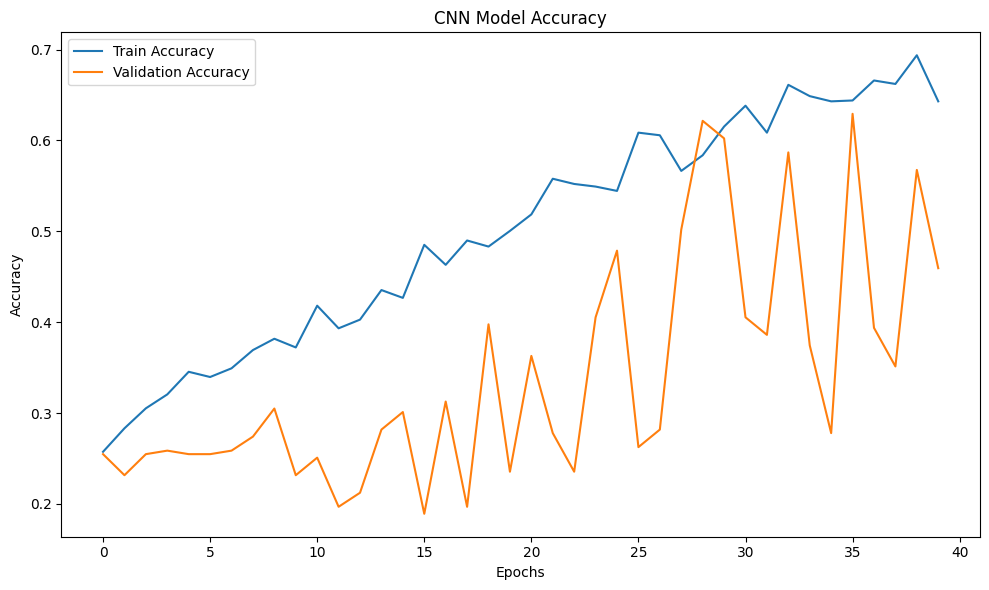

In [75]:
#plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [65]:
#Transfer learning model
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model

tl_model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(class_names), activation='softmax')
])

#compile transfer learning model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
tl_model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
#model summary
tl_model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_10     │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,597 (9.24 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [66]:
with tf.device('/GPU:0'):
    tl_history = tl_model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=30
    )

Epoch 1/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 22s 594ms/step - accuracy: 0.3668 - loss: 1.5515 - val_accuracy: 0.8494 - val_loss: 0.6208
Epoch 2/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 546ms/step - accuracy: 0.7023 - loss: 0.8120 - val_accuracy: 0.8031 - val_loss: 0.5579
Epoch 3/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 542ms/step - accuracy: 0.7754 - loss: 0.6554 - val_accuracy: 0.8803 - val_loss: 0.3937
Epoch 4/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 543ms/step - accuracy: 0.8156 - loss: 0.5376 - val_accuracy: 0.8919 - val_loss: 0.3377
Epoch 5/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 556ms/step - accuracy: 0.8402 - loss: 0.5052 - val_accuracy: 0.8958 - val_loss: 0.3427
Epoch 6/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 550ms/step - accuracy: 0.8747 - loss: 0.3829 - val_accuracy: 0.8919 - val_loss: 0.3285
Epoch 7/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 547ms/step - accuracy: 0.8787 - loss: 0.4077 - val_accuracy: 0.8726 - val_loss: 0.3610
Epoch 8/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 553ms/step - accuracy: 0.8993 - loss: 0.3111 - val_accu

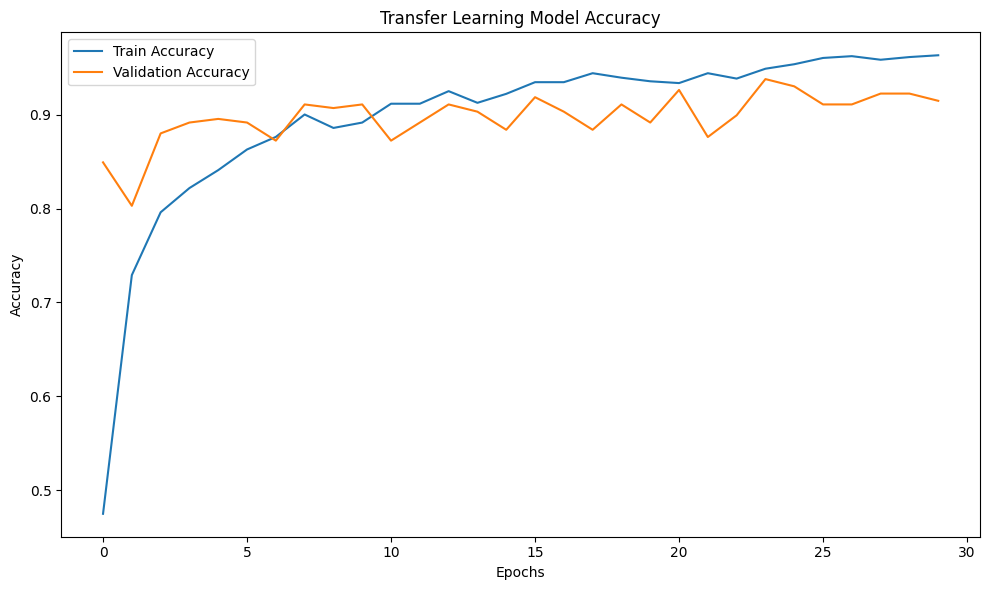

In [74]:
#plot training history
plt.figure(figsize=(10, 6))
plt.plot(tl_history.history['accuracy'], label='Train Accuracy')
plt.plot(tl_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Transfer Learning Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [76]:
#saving tl model
tl_model.save('yoga_transfer_learning_model.keras')